# Reproduction of Fig. S3

ARF bias considering positional dependency

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.visualization import ColorUniversalDesign as CUD

metadata = Metadata()

In [2]:
Z_stop_summary = pd.read_pickle(path2.data/'position-bias-Z.pkl.bz2')

In [3]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

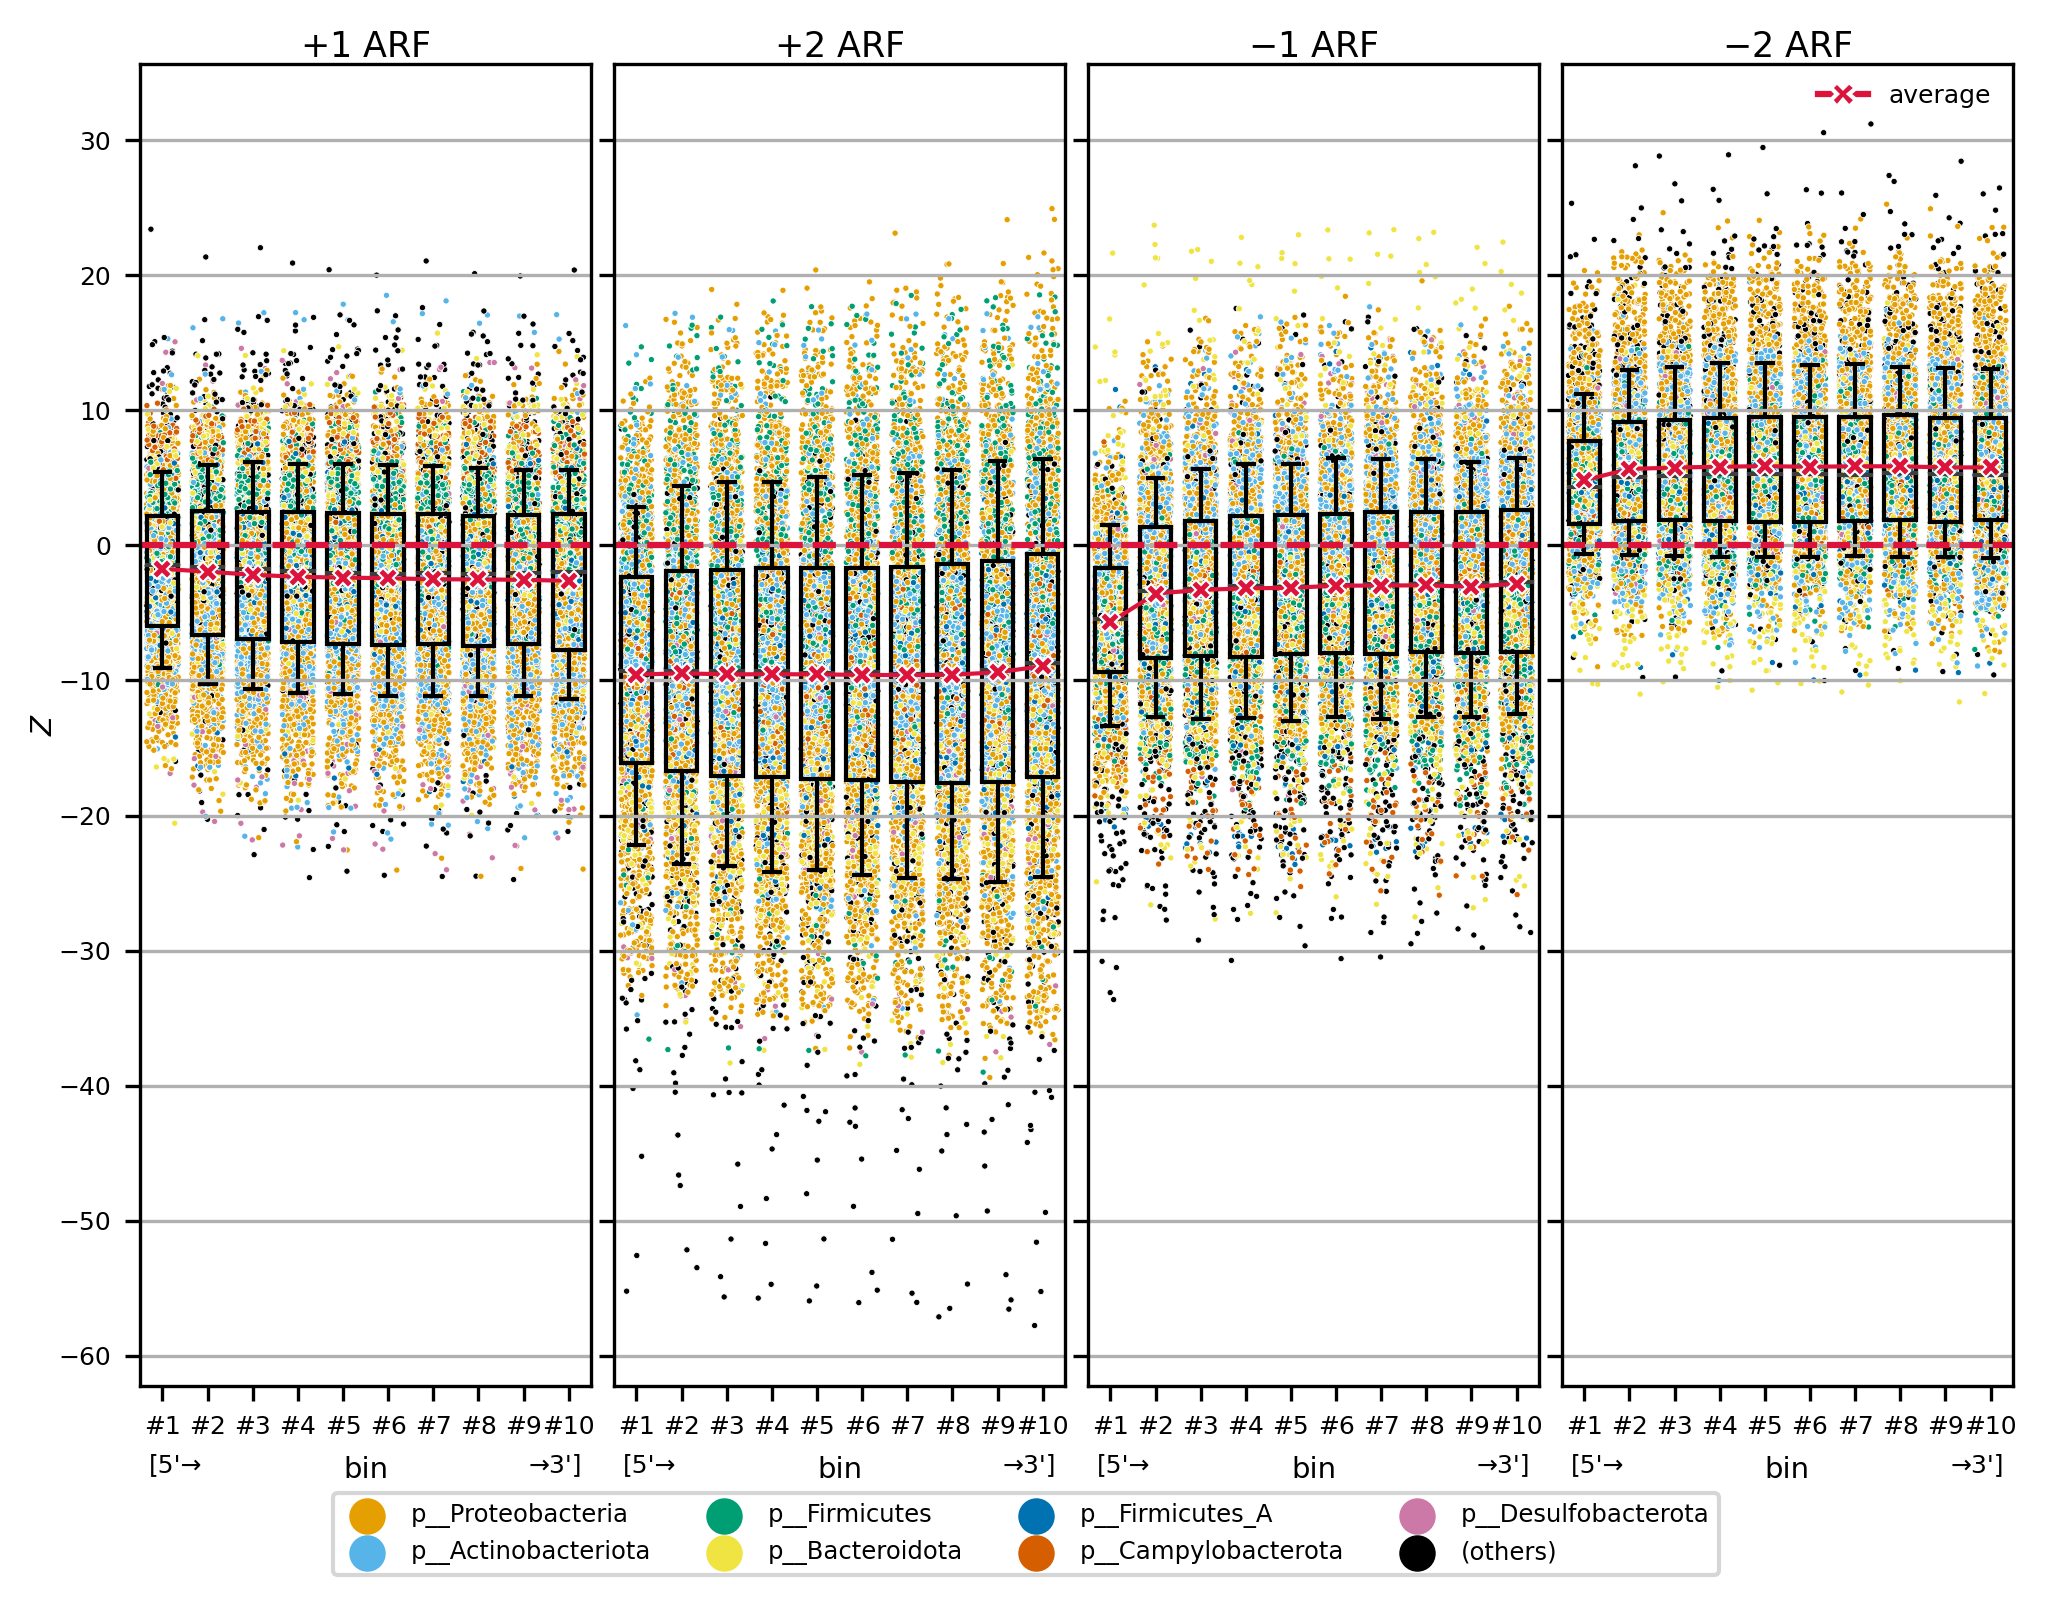

In [10]:
mm = 1 / 25.4

with plt.rc_context({'font.size': 7, 'xtick.labelsize': 6, 'ytick.labelsize': 6}):
    fig, axes = plt.subplots(1, 4, figsize=(174*mm, 135*mm), dpi=300, sharex=True, sharey=True)
    for frame, ax in zip(['+1','+2','-1','-2'], axes.flatten()):
        sns.lineplot(
            x='bin', y='mean', zorder=3, color='crimson',
            data=Z_stop_summary[frame].mean(axis=1).rename('mean').reset_index().assign(sty='mean'), ax=ax,
            lw=1, style='sty', markers='X', ms=5, mew=0.5
        )
        pltdata = Z_stop_summary[frame].unstack().rename('Z').reset_index()
        pltdata = pltdata.assign(phylum=pltdata['refseq'].map(refseq2gtdbrep).map(phylum_masked))
        sns.stripplot(
            x='bin', y='Z', data=pltdata, ax=ax, jitter=0.35, s=1.5, ec='w', linewidth=0.2, zorder=0,
            hue='phylum', hue_order=[*top_idx, '(others)'], palette=CUD.OkabeIto_cpal,
        )    
        sns.boxplot(
            x='bin', y='Z', data=pltdata, width=0.7,
            linewidth=1, ax=ax, capprops={'color':'k', 'zorder': 1}, whiskerprops={'color':'k', 'zorder': 1}, boxprops={'facecolor':'none', 'edgecolor':'k', 'zorder': 1}, whis=[10, 90], fliersize=0
        )
        ax.set_ylabel('$Z$', labelpad=0)
        ax.legend().remove()
        ax.yaxis.set_major_locator(plt.MultipleLocator(10))
        ax.yaxis.grid()
        ax.axhline(c='crimson', ls='--')
        ax.set_title(f'${frame}$ ARF', pad=0.05)
        ax.text(0.02, -0.06, '[5\'→', ha='left' , va='center', size=6, transform=ax.transAxes)
        ax.text(0.98, -0.06, '→3\']', ha='right', va='center', size=6, transform=ax.transAxes)
    
    else:
        han, lab = ax.get_legend_handles_labels()
        ax.legend([plt.Line2D([0], [0], color='crimson', marker='X', mec='w')], ['average'], frameon=False, bbox_to_anchor=(1, 0.95), loc='lower right', fontsize=6)
        fig.legend(han[1:], lab[1:], loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.07), fontsize='small')

        ymax = max(map(abs, ax.get_ylim()))
        #ax.set_ylim(-ymax, ymax)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, bottom=0.13)
    fig.savefig('./Figs/FigS3.pdf')
    fig.patch.set_facecolor('w')
    fig.savefig('./Figs/FigS3.tif')